In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import xarray as xr
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
import seaborn_image as isns
import calendar
import string

In [2]:
import plotly.io as pio
pio.renderers.default='jupyterlab'

In [3]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="Times")
sns.set_context(font_scale=0.8)

In [4]:
mesh_mask = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/masks/mesh_mask.nc')

In [5]:
mask = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/masks/tmaskm.nc')

In [6]:
base_eu_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_baseline_2.6_weighted.nc', decode_times=True)
oae_eu_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_oae_2.6_weighted.nc', decode_times=True)

base_eu_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/co2flux_baseline_7.0_weighted.nc', decode_times=True)
oae_eu_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/co2flux_oae_7.0_weighted.nc', decode_times=True)

base_dp_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/CO2flux_Baseline_2.6_cropped.nc', decode_times=True)
oae_dp_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/CO2flux_OAE_2.6_cropped.nc', decode_times=True)

base_dp_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/CO2flux_Baseline_7.0_cropped.nc', decode_times=True)
oae_dp_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/CO2flux/CO2flux_OAE_7.0_cropped.nc', decode_times=True)

### define ocean area

In [7]:
mask = mask.tmask.isel(time=0)

In [8]:
# calculate volume for each grid cell

dx = mesh_mask.e1t 
dy = mesh_mask.e2t
grid_cell_area = dx * dy # m2

In [9]:
gridded_mesh = grid_cell_area.isel(t=0)

In [10]:
# apply mask to weighted grid cells

ocean_area = gridded_mesh * mask

In [11]:
ocean_area_sliced = ocean_area.sel(x=slice(520,595),y=slice(330,435),z=0)
ocean_area_sliced_dp = ocean_area_sliced.isel(x=slice(58,60),y=slice(41,43))

In [12]:
base_dp_26 = base_dp_26.isel(x=slice(58,60),y=slice(41,43))
oae_dp_26 = oae_dp_26.isel(x=slice(58,60),y=slice(41,43))
base_dp_70 = base_dp_70.isel(x=slice(58,60),y=slice(41,43))
oae_dp_70 = oae_dp_70.isel(x=slice(58,60),y=slice(41,43))

In [13]:
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=height + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

In [14]:
def annualavg(co2flux):
    
    co2flux = co2flux.sel(time_counter=slice('2090','2100'))
    co2flux = ((co2flux.co2flux * 31536000 * ocean_area_sliced / 3.6667) * 1e-12).sum(['x','y']) # kg/m2/yr CO2
    co2flux = co2flux.sel(time=0).drop('time').to_dataset(name='co2flux')
    month_length_baseline = co2flux.time_counter.dt.days_in_month
    co2flux = ((co2flux * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum()).to_dataframe()
    co2flux = (co2flux.groupby(co2flux.index.month).mean()).reset_index()
    co2flux['time_counter'] = co2flux['time_counter'].apply(lambda x: calendar.month_abbr[x])
    return(co2flux)

In [15]:
base_eu_26 = annualavg(base_eu_26)
oae_eu_26 = annualavg(oae_eu_26)
base_eu_70 = annualavg(base_eu_70)
oae_eu_70 = annualavg(oae_eu_70)

In [18]:
def annualavg_dp(co2flux):
    co2flux = co2flux.sel(time_counter=slice('2090','2100'))
    co2flux = ((co2flux.co2flux * 31536000 * ocean_area_sliced_dp / 3.6667) * 1e-12).sum(['x', 'y'])
    co2flux = co2flux.sel(time=0).drop('time').to_dataset(name='co2flux')
    month_length_baseline = co2flux.time_counter.dt.days_in_month
    co2flux = ((co2flux * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum()).to_dataframe()
    co2flux = (co2flux.groupby(co2flux.index.month).mean()).reset_index()
    co2flux['time_counter'] = co2flux['time_counter'].apply(lambda x: calendar.month_abbr[x])
    return(co2flux)

In [19]:
base_dp_26 = annualavg_dp(base_dp_26)
oae_dp_26 = annualavg_dp(oae_dp_26)
base_dp_70 = annualavg_dp(base_dp_70)
oae_dp_70 = annualavg_dp(oae_dp_70)

In [20]:
def comp(oae, baseline):
    baseline = baseline.set_index('time_counter')
    oae = oae.set_index('time_counter')
    delta = (oae.co2flux - baseline.co2flux).to_xarray().to_dataframe('co2flux').reset_index()
    return(delta)

In [21]:
delta_mean_eu_26 = comp(oae_eu_26, base_eu_26)
delta_mean_eu_70 = comp(oae_eu_70, base_eu_70)
delta_mean_dp_26 = comp(oae_dp_26, base_dp_26)
delta_mean_dp_70 = comp(oae_dp_70, base_dp_70)

In [22]:
colors_month_co2flux = dict(zip(base_eu_26.time_counter.unique(), 
                        ['powderblue', 'darkcyan', 'forestgreen', 'darkseagreen', 
                        'honeydew', 'bisque', 'khaki', 'gold', 
                        'sandybrown', 'lightcoral', 'chocolate', 'cadetblue']))

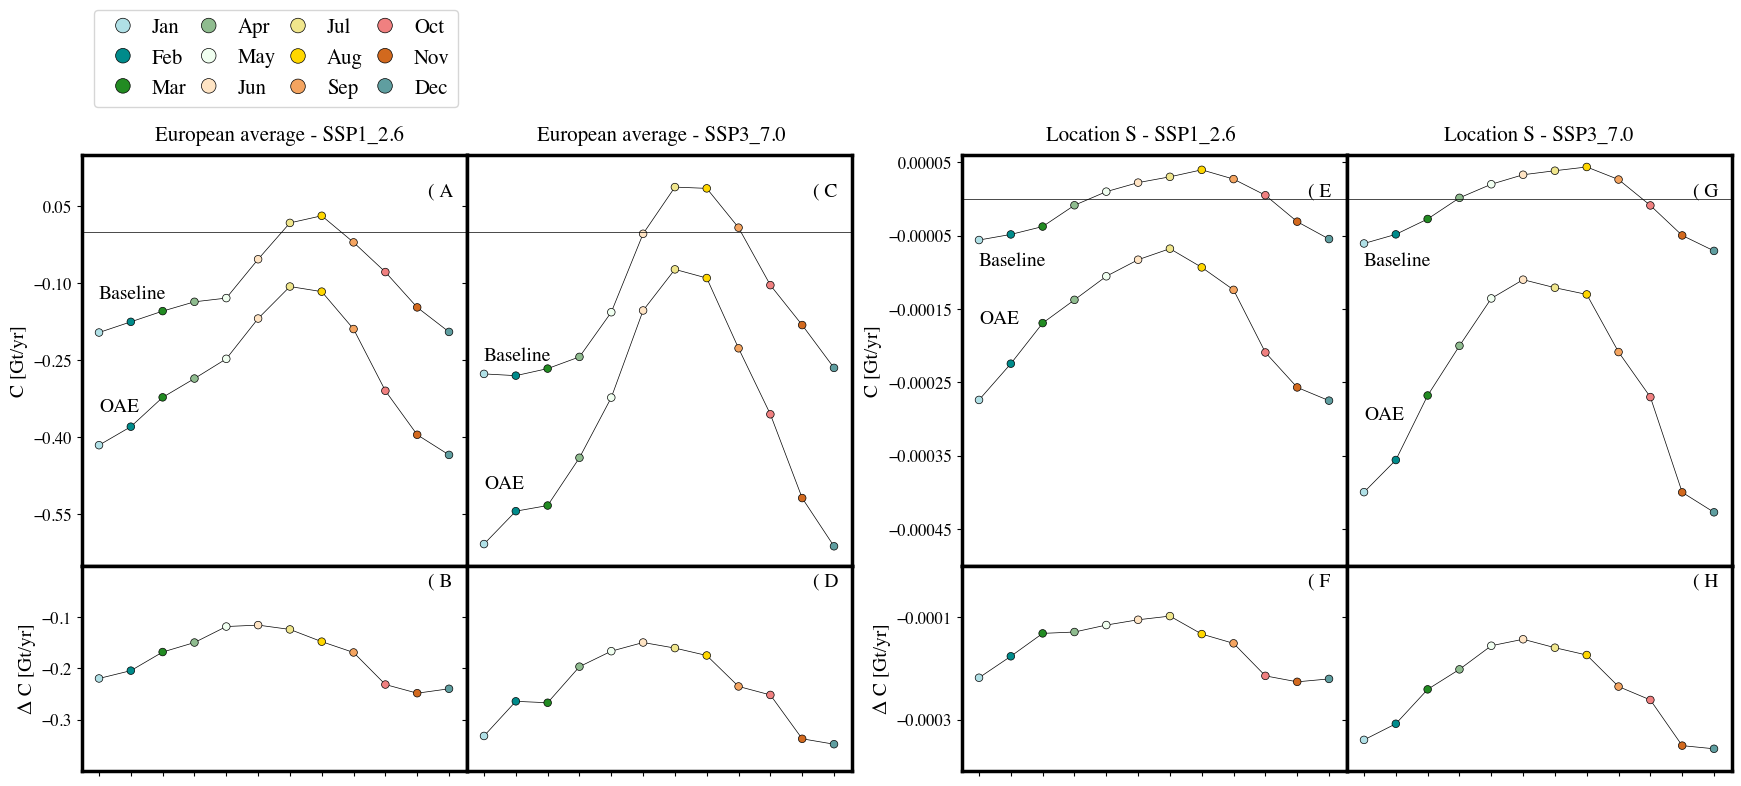

In [23]:
f = plt.figure(figsize=(22, 8)) 
gs_left = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2, 1])
gs_right = f.add_gridspec(nrows=2, ncols=4, height_ratios=[2, 1])

ax1 = plt.subplot(gs_left[0,0])
ax2 = plt.subplot(gs_left[1,0])
ax3 = plt.subplot(gs_left[0,1], sharey = ax1)
ax4 = plt.subplot(gs_left[1,1], sharey = ax2)
ax5 = plt.subplot(gs_right[0,2])
ax6 = plt.subplot(gs_right[1,2])
ax7 = plt.subplot(gs_right[0,3], sharey = ax5)
ax8 = plt.subplot(gs_right[1,3], sharey = ax6)

gs_left.update(wspace=0, hspace=0, left=0, right=0.7)
gs_right.update(wspace=0, hspace=0, left=0.05, right=0.75)

ax1.plot(base_eu_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax1.scatter(base_eu_26.time_counter, base_eu_26.co2flux, color=base_eu_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax1.plot(oae_eu_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax1.scatter(oae_eu_26.time_counter, oae_eu_26.co2flux, color=oae_eu_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.plot(delta_mean_eu_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax2.scatter(delta_mean_eu_26.time_counter, delta_mean_eu_26.co2flux, color=delta_mean_eu_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax3.plot(base_eu_70.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax3.scatter(base_eu_70.time_counter, base_eu_70.co2flux, color=base_eu_70.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax3.plot(oae_eu_70.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax3.scatter(oae_eu_70.time_counter, oae_eu_70.co2flux, color=oae_eu_70.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
ax3.tick_params(axis='y', which='major', labelsize=12)

ax4.plot(delta_mean_eu_70.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax4.scatter(delta_mean_eu_70.time_counter, delta_mean_eu_70.co2flux, color=delta_mean_eu_70.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax5.plot(base_dp_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax5.scatter(base_dp_26.time_counter, base_dp_26.co2flux, color=base_dp_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax5.plot(oae_dp_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax5.scatter(oae_dp_26.time_counter, oae_dp_26.co2flux, color=oae_dp_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
ax5.tick_params(axis='y', which='major', labelsize=12)

ax6.plot(delta_mean_dp_26.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax6.scatter(delta_mean_dp_26.time_counter, delta_mean_dp_26.co2flux, color=delta_mean_dp_26.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax7.plot(base_dp_70.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax7.scatter(base_dp_70.time_counter, base_dp_70.co2flux, color=base_dp_70.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

ax7.plot(oae_dp_70.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax7.scatter(oae_dp_70.time_counter, oae_dp_70.co2flux, color=oae_dp_70.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)
ax7.tick_params(axis='y', which='major', labelsize=12)

ax8.plot(delta_mean_dp_70.co2flux, '-', color="black", linewidth=0.5, zorder=1)
ax8.scatter(delta_mean_dp_70.time_counter, delta_mean_dp_70.co2flux, color=delta_mean_dp_70.time_counter.map(lambda x: colors_month_co2flux[x]), edgecolors='black',  linewidth=0.5, s=30)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for ax in axes:
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.tick_params(axis='y', which='major', labelsize=12)
for n, ax in enumerate(axes):
    ax.text(0.9, 0.9, string.punctuation[7] + ' ' + string.ascii_uppercase[n], transform=ax.transAxes, 
            size=14, weight='bold', color='black')

ax1.set_ylabel('C [Gt/yr]', fontsize=14)
ax2.set_ylabel('Δ C [Gt/yr]', fontsize=14)
ax5.set_ylabel('C [Gt/yr]', fontsize=14)
ax6.set_ylabel('Δ C [Gt/yr]', fontsize=14)

ax1.text(0, -0.13, s='Baseline', fontsize=14)
ax1.text(0, -0.35, s='OAE', fontsize=14)
ax3.text(0, -0.25, s='Baseline', fontsize=14)
ax3.text(0, -0.5, s='OAE', fontsize=14)
ax5.text(0, -0.00009, s='Baseline', fontsize=14)
ax5.text(0, -0.00017, s='OAE', fontsize=14)
ax7.text(0, -0.00009, s='Baseline', fontsize=14)
ax7.text(0, -0.0003, s='OAE', fontsize=14)

start1, end1 = ax1.set_ylim(-0.65, 0.15)
ax1.yaxis.set_ticks(np.arange(start1+0.1, end1, 0.15))
start2, end2 = ax2.set_ylim(-0.4, 0)
ax2.yaxis.set_ticks(np.arange(start2+0.1, end2-0.1, 0.1))
start5, end5 = ax5.set_ylim(-0.0005, 0.00006)
ax5.yaxis.set_ticks(np.arange(start5+0.00005, end5, 0.0001))
start6, end6 = ax6.set_ylim(-0.0004, 0)
ax6.yaxis.set_ticks(np.arange(start6+0.0001, end6, 0.0002))

axtick = [ax3, ax4, ax7, ax8]
for ax in axtick:
    ax.yaxis.set_tick_params(labelleft=False)
    
axline = [ax1, ax3, ax5, ax7]
for ax in axline:
    ax.axhline(0, color='black', linewidth=0.5)
    
ax.text(-38,0.00008, 'European average - SSP1_2.6')
ax.text(-26, 0.00008, 'European average - SSP3_7.0')
ax.text(-10, 0.00008, 'Location S - SSP1_2.6')
ax.text(2.5,0.00008, 'Location S - SSP3_7.0')

legend = [mpatches.Circle((0.5, 0.5), 1, facecolor = value, edgecolor = "black", linewidth=0.5, label = key, alpha = 1) for key, value in colors_month_co2flux.items()]
ax.legend(handles = legend, bbox_to_anchor=(-2.28,1.38), loc='best', columnspacing=0.05, handletextpad=0.4, fontsize=15, ncol = 4, handler_map={mpatches.Circle: HandlerEllipse()})

plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/seasonal_analysis/final_figs/carbon_inventory.png')